# 基于第二次世界大战天气状况的探索性数据分析与预测-part1-数据探索

## 任务目的

对二战中的空袭行动与天气状况数据进行分析，基于第二次世界大战中的空中轰炸行动和天气状况的多种数据源，利用 EDA (Exploratory Data Analysis)分析数据并对数据进行清理，根据时间序列预测方式，预测出轰炸目标城市、天气状况以及行动何时完成等。

## 任务内容

- 下载数据集
- 数据清洗
- 数据可视化
  - 袭击了多少个国家
  - 主要目标国家
  - 十大飞机系列
  - 起飞基地位置（攻击国家）
  - 目标位置
  - 轰炸路径
  - 战区
  - 气象站位置
- 基于 ARIMA 的时间序列预测
  - 时间序列的季节性趋势
  - 检查时间序列的平稳性
  - 避免趋势性和季节性的方法
  - 预测时间序列
  - 使用（1,0,1）作为 ARIMA 模型的参数并预测
  - 预测和可视化所有路径并查找均方误差


### 数据清洗

- EDA: Exploratory Data Analysis
- 空袭数据包含了大量的 NaN 值。项目中没有使用它们，而是删除了一些 NaN 值。它不仅消除了不确定性，而且是一个可视化的过程。
  - 删除值为 NaN 的国家
  - 如果目标经度为 NaN，则删除
  - 起飞经度为 NaN 时删除
  - 删除未使用的特征
- 天气状况数据不需要任何清理。通过对勘探数据的分析和可视化，选择一定的地点进行深入研究。只放入使用的数据变量。


In [18]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import chart_studio.plotly as py
from plotly.offline import init_notebook_mode, iplot

init_notebook_mode(connected=True)

import plotly.graph_objs as go

# plt.style.use("ggplot")

import warnings

warnings.filterwarnings("ignore")

In [19]:
import os
import sys

data_path = "./data"
print(os.listdir(data_path))

# 二战中的空中轰炸行动（Aerial Bombing Operations in WW2）
# 这一数据包括轰炸行动。例如，1945 年，美国使用庞特奥利沃机场炸弹德国（柏林）和A36 飞机。
aerial_path = os.path.join(data_path, "operations.csv")

# 二战期间的天气状况（Wether Conditions in WW2）
# 二战期间的天气状况。例如，根据乔治镇气象站，1942 年 1 月 7 日的平均气温是 23.88 度。该数据集中有 2 个子集：
# 第一个包括气象站的位置，如国家、纬度和经度。
weather_station_location_path = os.path.join(data_path, "Weather Station Locations.csv")
# 第二个包括气象站的测量最低、最高和平均温度。
weather_path = os.path.join(data_path, "Summary of Weather.csv")

['Weather Station Locations.csv', 'operations.csv', 'Summary of Weather.csv']


In [20]:
aerial = pd.read_csv(aerial_path)
weather_station_location = pd.read_csv(weather_station_location_path)
weather = pd.read_csv(weather_path)

In [21]:
# Exploratory Data Analysis
aerial.head()
aerial.describe()
aerial.info()

weather_station_location.head()
weather_station_location.info()

weather.head()
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178281 entries, 0 to 178280
Data columns (total 46 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   Mission ID                             178281 non-null  int64  
 1   Mission Date                           178281 non-null  object 
 2   Theater of Operations                  175123 non-null  object 
 3   Country                                126494 non-null  object 
 4   Air Force                              126444 non-null  object 
 5   Unit ID                                50913 non-null   object 
 6   Aircraft Series                        178165 non-null  object 
 7   Callsign                               21 non-null      object 
 8   Mission Type                           47186 non-null   object 
 9   Takeoff Base                           3383 non-null    object 
 10  Takeoff Location                       3338 non-null    

In [22]:
# Data Cleaning: aerial

# drop countries that are NaN
aerial = aerial[pd.isna(aerial["Country"]) == False]
# drop if target longitude is NaN
aerial = aerial[pd.isna(aerial["Target Longitude"]) == False]
# Drop if takeoff longitude is NaN
aerial = aerial[pd.isna(aerial["Takeoff Longitude"]) == False]
# drop unused features
drop_list = [
    "Mission ID",
    "Unit ID",
    "Target ID",
    "Altitude (Hundreds of Feet)",
    "Airborne Aircraft",
    "Attacking Aircraft",
    "Bombing Aircraft",
    "Aircraft Returned",
    "Aircraft Failed",
    "Aircraft Damaged",
    "Aircraft Lost",
    "High Explosives",
    "High Explosives Type",
    "Mission Type",
    "High Explosives Weight (Pounds)",
    "High Explosives Weight (Tons)",
    "Incendiary Devices",
    "Incendiary Devices Type",
    "Incendiary Devices Weight (Pounds)",
    "Incendiary Devices Weight (Tons)",
    "Fragmentation Devices",
    "Fragmentation Devices Type",
    "Fragmentation Devices Weight (Pounds)",
    "Fragmentation Devices Weight (Tons)",
    "Total Weight (Pounds)",
    "Total Weight (Tons)",
    "Time Over Target",
    "Bomb Damage Assessment",
    "Source ID",
]
aerial.drop(drop_list, axis=1, inplace=True)
aerial = aerial[aerial.iloc[:, 8] != "4248"]  # drop this takeoff latitude
aerial = aerial[aerial.iloc[:, 9] != 1355]  # drop this takeoff longitude

In [23]:
aerial.describe()
aerial.head()
aerial.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2555 entries, 0 to 178080
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Mission Date           2555 non-null   object 
 1   Theater of Operations  2555 non-null   object 
 2   Country                2555 non-null   object 
 3   Air Force              2505 non-null   object 
 4   Aircraft Series        2528 non-null   object 
 5   Callsign               10 non-null     object 
 6   Takeoff Base           2555 non-null   object 
 7   Takeoff Location       2555 non-null   object 
 8   Takeoff Latitude       2555 non-null   object 
 9   Takeoff Longitude      2555 non-null   float64
 10  Target Country         2499 non-null   object 
 11  Target City            2552 non-null   object 
 12  Target Type            602 non-null    object 
 13  Target Industry        81 non-null     object 
 14  Target Priority        230 non-null    object 
 15  Target 

In [24]:
# Data Cleaning: weather locations
# what we will use only
weather_station_location = weather_station_location.loc[
    :, ["WBAN", "NAME", "STATE/COUNTRY ID", "Latitude", "Longitude"]
]
weather_station_location.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161 entries, 0 to 160
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   WBAN              161 non-null    int64  
 1   NAME              161 non-null    object 
 2   STATE/COUNTRY ID  161 non-null    object 
 3   Latitude          161 non-null    float64
 4   Longitude         161 non-null    float64
dtypes: float64(2), int64(1), object(2)
memory usage: 6.4+ KB


In [25]:
# Data Cleaning: weather
# what we will use only
weather = weather.loc[:, ["STA", "Date", "MeanTemp"]]
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119040 entries, 0 to 119039
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   STA       119040 non-null  int64  
 1   Date      119040 non-null  object 
 2   MeanTemp  119040 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 2.7+ MB


### 数据可视化

- 袭击了多少个国家
- 主要目标国家
- 十大飞机系列
- 起飞基地位置（攻击国家）
- 目标位置
- 轰炸路径
- 战区
- 气象站位置


Country
USA              1895
GREAT BRITAIN     544
NEW ZEALAND       102
SOUTH AFRICA       14
Name: count, dtype: int64


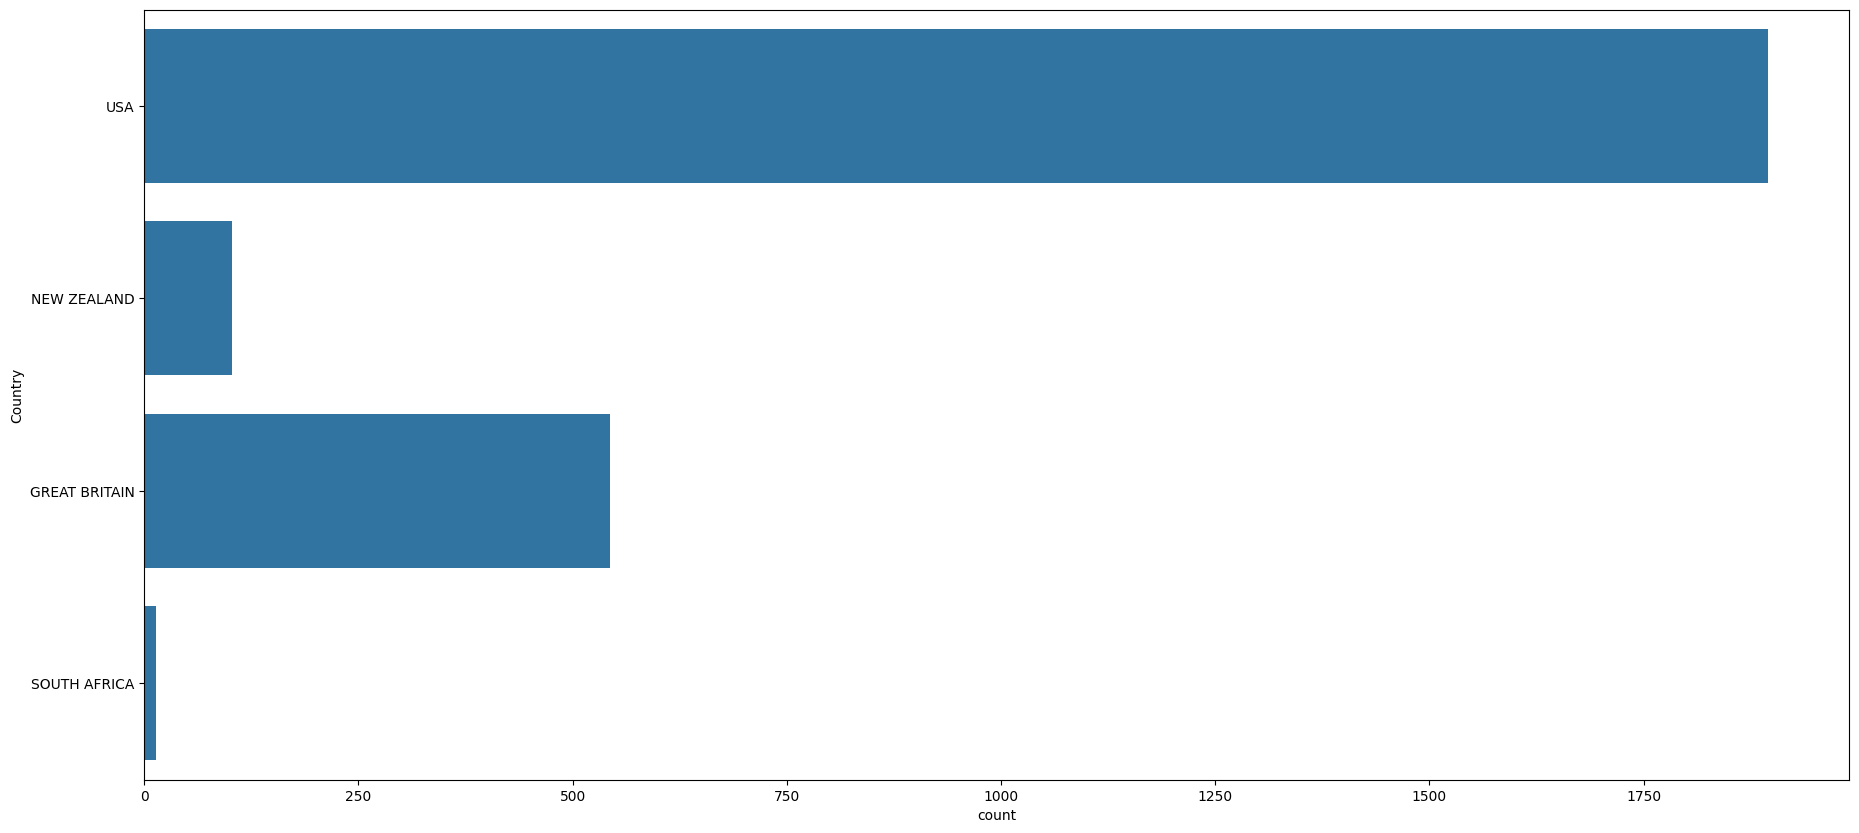

In [26]:
# country: 袭击了多少个国家
print(aerial["Country"].value_counts())
plt.figure(figsize=(22, 10))
sns.countplot(aerial["Country"])
plt.show()

Target Country
ITALY      1104
BURMA       335
LIBYA       272
TUNISIA     113
GREECE       87
EGYPT        80
JAPAN        71
CHINA        52
SICILY       46
GERMANY      41
Name: count, dtype: int64


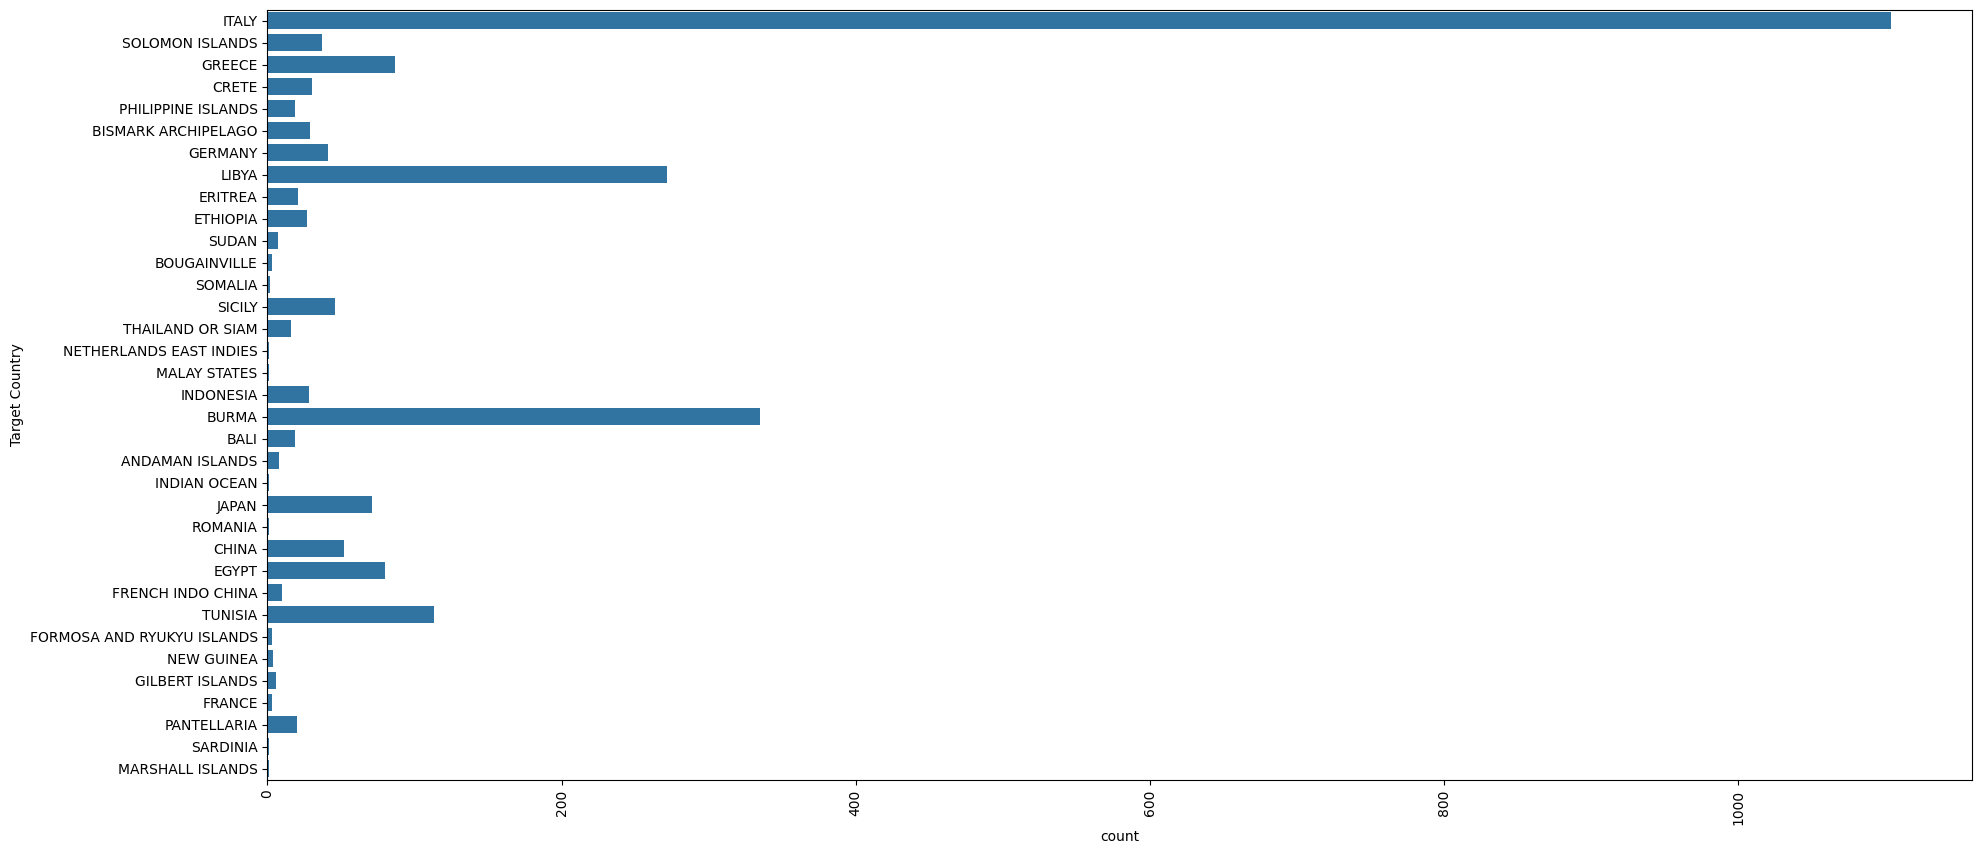

In [27]:
# Top target countries: 主要目标国家
print(aerial["Target Country"].value_counts()[:10])
plt.figure(figsize=(22, 10))
sns.countplot(aerial["Target Country"])
plt.xticks(rotation=90)
plt.show()

In [28]:
data = aerial["Aircraft Series"].value_counts()
data[:10].values

array([990, 416, 337, 180, 145, 129, 119,  70,  32,  18])

In [29]:
# nbformat
# This package contains the base implementation of the Jupyter Notebook format,
# and Python APIs for working with notebooks.

# Aircraft Series: 十大飞机系列
data = aerial["Aircraft Series"].value_counts()
print(data[:10])
data = [go.Bar(x=data[:10].index, y=data[:10].values)]

layout = dict(title="Aircraft Series")
fig = go.Figure(data=data, layout=layout)
iplot(fig)

Aircraft Series
A36             990
B25             416
B24             337
BLEN            180
LIB             145
WELL            129
B17             119
PV-1 VENTURA     70
WHIT             32
HALI             18
Name: count, dtype: int64


In [30]:
aerial["Target Country"].unique()
aerial["Country"].unique()

array(['USA', 'NEW ZEALAND', 'GREAT BRITAIN', 'SOUTH AFRICA'],
      dtype=object)

In [ ]:
tmp = (
    "Country: "
    + aerial.Country
    + " Takeoff Location: "
    + aerial["Takeoff Location"]
    + " Takeoff Base: "
    + aerial["Takeoff Base"]
)
# f"Country: {aerial.Country}, Takeoff Location: {aerial["Takeoff Location"]}, Takeoff Base: {aerial["Takeoff Base"]}"

In [32]:
# ATTACK: 起飞基地位置（攻击国家）
aerial["color"] = ""
aerial.color[aerial.Country == "USA"] = "rgb(255, 0, 0)"  # red
aerial.color[aerial.Country == "GREAT BRITAIN"] = "rgb(0, 255, 0)"  # green
aerial.color[aerial.Country == "NEW ZEALAND"] = "rgb(0, 0, 255)"  # blue
aerial.color[aerial.Country == "SOUTH AFRICA"] = "rgb(255, 255, 0)"  # yellow

data = [
    dict(
        type="scattergeo",
        lon=aerial["Takeoff Longitude"],
        lat=aerial["Takeoff Latitude"],
        hoverinfo="text",
        text="Country: "
        + aerial.Country
        + " Takeoff Location: "
        + aerial["Takeoff Location"]
        + " Takeoff Base: "
        + aerial["Takeoff Base"],
        mode="markers",
        marker=dict(
            line=dict(width=1, color="white"),
            color=aerial["color"],
            opacity=0.7,
        ),
    )
]

layout = dict(
    title="Countries Take Off Bases ",
    hovermode="closest",
    geo=dict(
        showframe=False,
        showland=True,
        showcoastlines=True,
        showcountries=True,
        countrywidth=1,
        projection=dict(type="mercator"),  # mercator: 墨卡托投影
    ),
)
fig = go.Figure(data=data, layout=layout)
iplot(fig)

In [33]:
aerial.color

0         rgb(255, 0, 0)
2         rgb(255, 0, 0)
3         rgb(255, 0, 0)
8         rgb(255, 0, 0)
9         rgb(255, 0, 0)
               ...      
178032    rgb(255, 0, 0)
178033    rgb(255, 0, 0)
178034    rgb(255, 0, 0)
178035    rgb(0, 255, 0)
178080    rgb(255, 0, 0)
Name: color, Length: 2555, dtype: object

In [ ]:
aerial["Takeoff Latitude"]
aerial["Takeoff Longitude"]
aerial["Target Longitude"].iloc[5]
# aerial["Target Latitude"]

np.float64(15.65)

In [ ]:
# Bombing paths: 轰炸路径
# Takeoff
airports = [
    dict(
        type="scattergeo",
        lon=aerial["Takeoff Longitude"],
        lat=aerial["Takeoff Latitude"],
        # hoverinfo="text",
        text="Country: "
        + aerial.Country
        + " Takeoff Location: "
        + aerial["Takeoff Location"]
        + " Takeoff Base: "
        + aerial["Takeoff Base"],
        mode="markers",
        marker=dict(size=5, color=aerial["color"], line=dict(width=1, color="white")),
    )
]

# Target
targets = [
    dict(
        type="scattergeo",
        lon=aerial["Target Longitude"],
        lat=aerial["Target Latitude"],
        # hoverinfo="text",
        text="Target Country: "
        + aerial["Target Country"]
        + " Target City: "
        + aerial["Target City"],
        mode="markers",
        marker=dict(size=1, color="red", line=dict(width=0.5, color="red")),
    )
]

# trace
flight_paths = []
for i in range(len(aerial["Target Longitude"])):
    aerial["Takeoff Longitude"].iloc[i]
    # print(aerial["Takeoff Longitude"][i], aerial["Target Longitude"][i])
    flight_paths.append(
        dict(
            type="scattergeo",
            lon=[
                aerial["Takeoff Longitude"].iloc[i],
                aerial["Target Longitude"].iloc[i],
            ],
            lat=[aerial["Takeoff Latitude"].iloc[i], aerial["Target Latitude"].iloc[i]],
            mode="lines",
            opacity=0.6,
        )
    )

layout = dict(
    title="Bombing Paths from Attacker Country to Target ",
    hovermode="closest",
    geo=dict(
        showframe=False,
        showland=True,
        showcoastlines=True,
        showcountries=True,
        countrywidth=1,
        projection=dict(type="mercator"),
    ),
)

fig = dict(data=flight_paths + airports + targets, layout=layout)
iplot(fig)

Theater of Operations
MTO            1991
CBI             425
PTO             247
ETO              63
EAST AFRICA      37
Name: count, dtype: int64


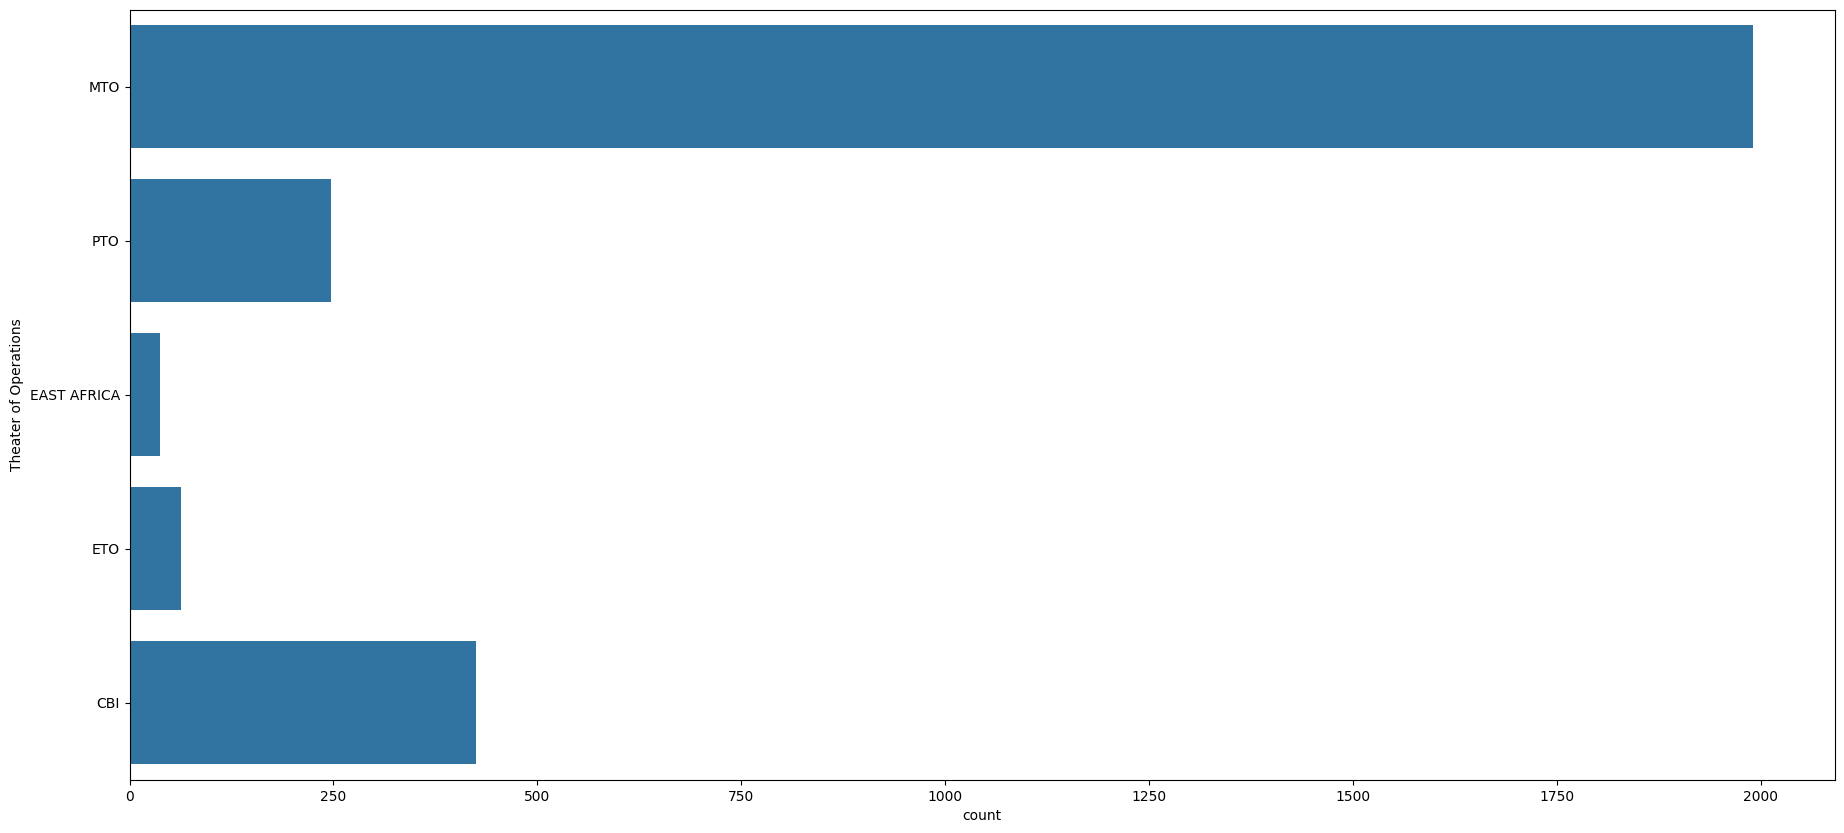

In [81]:
# Theater of Operations: 战区
print(aerial["Theater of Operations"].value_counts())
plt.figure(figsize=(22, 10))
sns.countplot(aerial["Theater of Operations"])
plt.show()

In [65]:
# weather station locations: 气象站位置

data = [
    dict(
        type="scattergeo",
        lon=weather_station_location.Longitude,
        lat=weather_station_location.Latitude,
        hoverinfo="text",
        text="Name: "
        + weather_station_location.NAME
        + " Country: "
        + weather_station_location["STATE/COUNTRY ID"],
        mode="markers",
        marker=dict(
            line=dict(width=1, color="white"),
            color="blue",
        ),
    )
]
layout = dict(
    title="Weather Station Locations ",
    hovermode="closest",
    geo=dict(
        showframe=False,
        showland=True,
        showcoastlines=True,
        showcountries=True,
        countrywidth=1,
        projection=dict(type="mercator"),
    ),
)
fig = go.Figure(data=data, layout=layout)
iplot(fig)

聚焦美缅战争:

- 在这场战争中，美国从 1942 年到 1945 年轰炸了缅甸（卡萨市）。
- 距离这场战争最近的气象站是宾杜库里，它有 1943 年至 1945 年的气温记录。

从 1943 年到 1945 年进行了温度测量。

- 温度在 12 到 32 度之间。
- 冬季的温度比夏季的温度低。


In [68]:
weather_station_location.head()

,WBAN,NAME,STATE/COUNTRY ID,Latitude,Longitude
0,33013,AIN EL,AL,36.383333,6.650000
1,33031,LA SENIA,AL,35.616667,0.583333
2,33023,MAISON BLANCHE,AL,36.716667,3.216667
3,33044,TELERGMA,AL,36.116667,6.416667
4,12001,TINDOUF,AL,27.683333,-8.083333


In [69]:
weather.head()

,STA,Date,MeanTemp
0,10001,1942-7-1,23.888889
1,10001,1942-7-2,25.555556
2,10001,1942-7-3,24.444444
3,10001,1942-7-4,24.444444
4,10001,1942-7-5,24.444444


In [67]:
weather_station_id = weather_station_location[
    weather_station_location.NAME == "BINDUKURI"  # 宾杜库里
].WBAN
weather_station_id

70    32907
Name: WBAN, dtype: int64

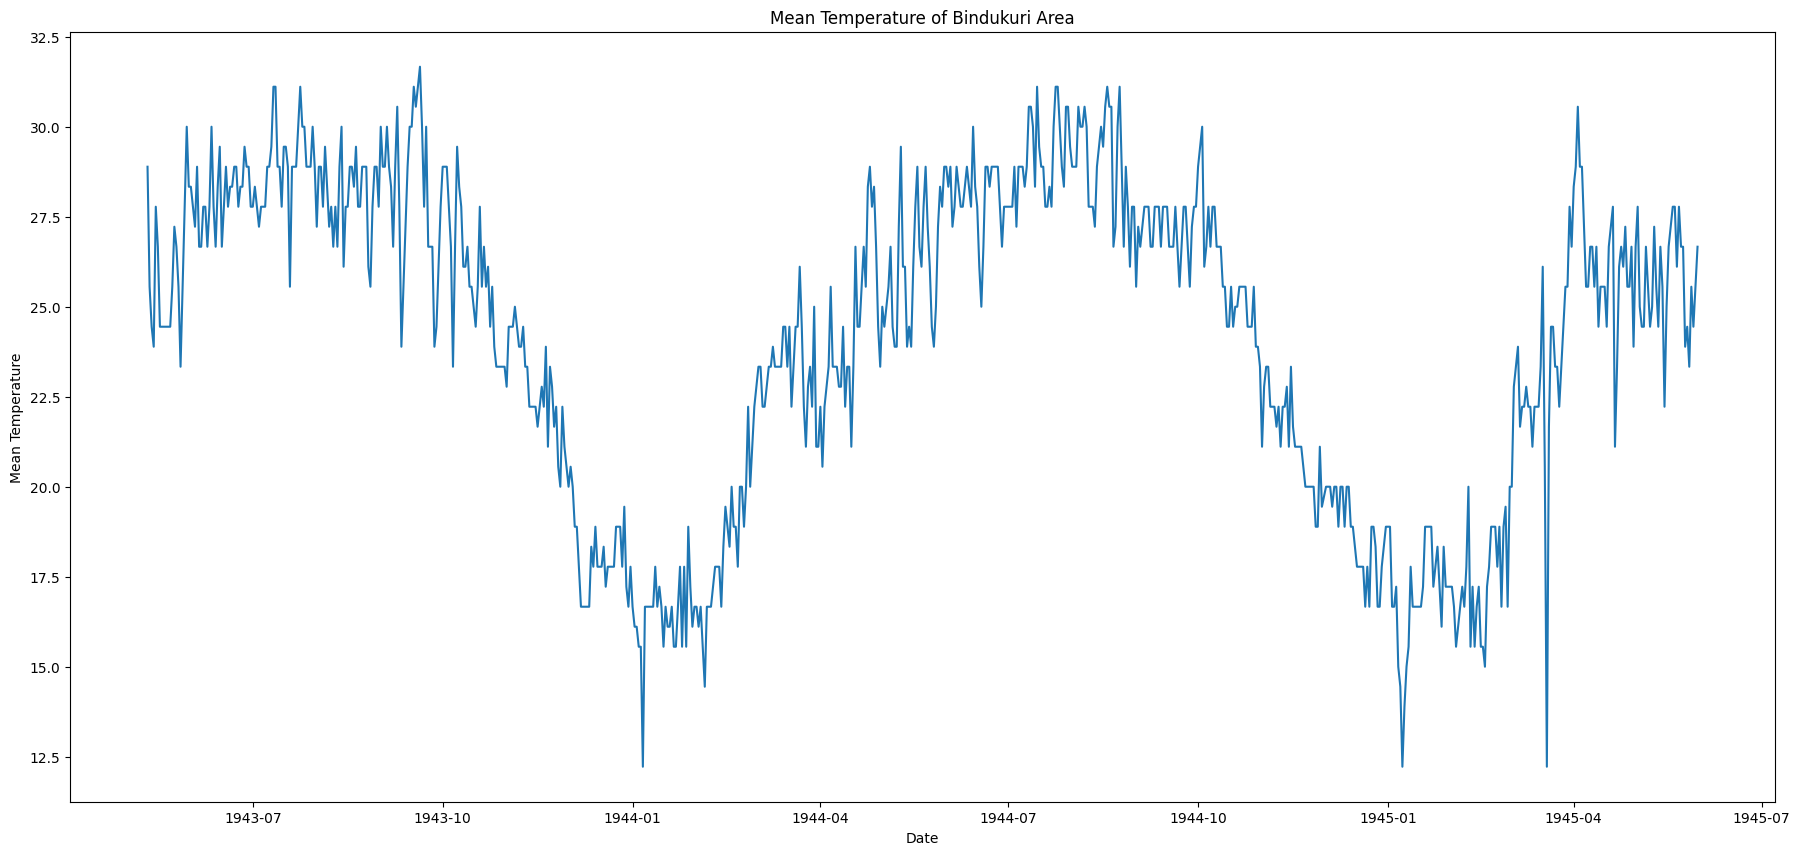

In [74]:
weather_bin = weather[weather.STA == 32907]
weather_bin["Date"] = pd.to_datetime(weather_bin["Date"])
plt.figure(figsize=(22, 10))
plt.plot(weather_bin.Date, weather_bin.MeanTemp)
plt.title("Mean Temperature of Bindukuri Area")
plt.xlabel("Date")
plt.ylabel("Mean Temperature")
plt.show()

In [77]:
aerial = pd.read_csv(aerial_path)
aerial["year"] = [each.split("/")[2] for each in aerial["Mission Date"]]
aerial["month"] = [each.split("/")[0] for each in aerial["Mission Date"]]
aerial = aerial[aerial["year"] >= "1943"]
aerial = aerial[aerial["month"] >= "8"]

aerial["Mission Date"] = pd.to_datetime(aerial["Mission Date"])

attack = "USA"
target = "BURMA"
city = "KATHA"

aerial_war = aerial[aerial.Country == attack]
aerial_war = aerial_war[aerial_war["Target Country"] == target]
aerial_war = aerial_war[aerial_war["Target City"] == city]

In [80]:
aerial_war.head()

,Mission ID,Mission Date,Theater of Operations,Country,Air Force,Unit ID,Aircraft Series,Callsign,Mission Type,Takeoff Base,...,Fragmentation Devices Weight (Pounds),Fragmentation Devices Weight (Tons),Total Weight (Pounds),Total Weight (Tons),Time Over Target,Bomb Damage Assessment,Source ID,year,month,dene
3740,3741,1944-08-02,CBI,USA,10 AF,528 FS,P51,NaN,10,NaN,...,NaN,NaN,NaN,1.0,NaN,NaN,30767.0,1944,8,[28.88888889]
10023,10024,1943-09-20,CBI,USA,10 AF,490 BS,B25,NaN,1,NaN,...,NaN,NaN,NaN,10.0,NaN,NaN,30792.0,1943,9,[31.66666667]
10938,10939,1943-09-24,CBI,USA,10 AF,22 BS,B25,NaN,1,NaN,...,NaN,NaN,NaN,5.0,NaN,NaN,30765.0,1943,9,[26.66666667]
10942,10943,1943-09-24,CBI,USA,10 AF,22 BS,B25,NaN,1,NaN,...,NaN,NaN,NaN,1.0,NaN,NaN,30766.0,1943,9,[26.66666667]
20891,20892,1944-08-17,CBI,USA,10 AF,490 BS,B25,NaN,1.0,NaN,...,NaN,NaN,NaN,10.0,NaN,NaN,30809.0,1944,8,[30.55555556]


In [84]:
weather_bin.MeanTemp

78252    28.888889
78253    25.555556
78254    24.444444
78255    23.888889
78256    27.777778
           ...    
78998    23.333333
78999    25.555556
79000    24.444444
79001    25.555556
79002    26.666667
Name: MeanTemp, Length: 751, dtype: float64

In [ ]:
liste = []
aa = []

for each in aerial_war["Mission Date"]:
    dummy = weather_bin[weather_bin.Date == each]
    print(dummy)
    break
    # liste.append(dummy["MeanTemp"])
# liste[0].values
aerial_war["Mission Date"]

         STA       Date   MeanTemp
78701  32907 1944-08-02  28.888889


In [107]:
len(aa)
aerial_war["Mission Date"]

3740     1944-08-02
10023    1943-09-20
10938    1943-09-24
10942    1943-09-24
20891    1944-08-17
21144    1944-08-18
21145    1944-08-18
21147    1944-08-18
29396    1944-08-29
34375    1944-09-06
35569    1944-09-08
41328    1944-09-12
41332    1944-09-12
43754    1944-09-17
51899    1944-09-27
174745   1943-08-01
174746   1943-08-01
174749   1943-08-01
174750   1943-08-01
Name: Mission Date, dtype: datetime64[ns]

In [109]:
mission_date_temperature = []

for each in aerial_war["Mission Date"]:
    """
         STA       Date   MeanTemp
78701  32907 1944-08-02  28.888889
    """
    dummy = weather_bin[weather_bin.Date == each]
    mission_date_temperature.append(dummy["MeanTemp"].values[0])

# Create a trace
trace = go.Scatter(
    x=weather_bin.Date,
    y=weather_bin.MeanTemp,
    mode="lines",
    name="Mean Temperature",
)
trace1 = go.Scatter(
    x=aerial_war["Mission Date"],
    y=mission_date_temperature,
    mode="markers",
    name="Bombing temperature",
)
layout = dict(
    title="Mean Temperature --- Bombing Dates and Mean Temperature at this Date"
)
data = [trace, trace1]

fig = dict(data=data, layout=layout)
iplot(fig)